In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import keras
import copy
import tensorflow as tf
import seaborn as sn
import pandas as pd
import keras.backend as K
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, LSTM, Masking
from keras.models import Model
from keras.layers import Input
from sklearn import metrics
from model_helper import *

## 1. Load in dataset

In [12]:
cwd = os.getcwd()
parent_wd = cwd.replace('\model', '')
training_set_path = parent_wd + '/preprocessing/training_seq_n_12_rmrp0'
dev_set_path = parent_wd + '/preprocessing/dev_seq_n_12_rmrp0'
test_set_path = parent_wd + '/preprocessing/test_seq_n_12_rmrp0'

In [14]:
with open(training_set_path, 'rb') as f:
    training_set = pickle.load(f)
with open(dev_set_path, 'rb') as f:
    dev_set = pickle.load(f)
with open(test_set_path, 'rb') as f:
    test_set = pickle.load(f)

In [15]:
X_train = training_set['X']
Y_train = training_set['Y']
X_dev = dev_set['X']
Y_dev = dev_set['Y']
X_test = test_set['X']
Y_test = test_set['Y']

## 2. Define GradeNet Model

In [16]:
np.random.seed(0)
tf.random.set_seed(0)
inputs = Input(shape = (12, 22))
mask = Masking(mask_value = 0.).compute_mask(inputs)
lstm0 = LSTM(20, activation='tanh', input_shape=(12, 22), kernel_initializer='glorot_normal', return_sequences = 'True')(
    inputs, mask = mask)
dense1 = Dense(100, activation='relu', kernel_initializer='glorot_normal')(lstm0)
dense2 = Dense(80, activation='relu', kernel_initializer='glorot_normal')(dense1)
dense3 = Dense(75, activation='relu', kernel_initializer='glorot_normal')(dense2)
dense4 = Dense(50, activation='relu', kernel_initializer='glorot_normal')(dense3)
dense5 = Dense(20, activation='relu', kernel_initializer='glorot_normal')(dense4)
dense6 = Dense(10, activation='relu', kernel_initializer='glorot_normal')(dense5)
flat = Flatten()(dense6)
softmax2 = Dense(10, activation='softmax', name = 'softmax2')(flat)
lstm1 = LSTM(20, activation='tanh', kernel_initializer='glorot_normal', return_sequences = True)(dense6)
lstm2 = LSTM(20, activation='tanh', kernel_initializer='glorot_normal')(lstm1)
dense7 = Dense(15, activation='relu', kernel_initializer='glorot_normal')(lstm2)
dense8 = Dense(15, activation='relu', kernel_initializer='glorot_normal')(dense7)
softmax3 = Dense(10, activation='softmax', name = 'softmax2')(dense8)

def custom_loss(layer):
    def loss(y_true,y_pred):
        loss1 = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss2 = K.sparse_categorical_crossentropy(y_true, layer)
        return K.mean(loss1 + loss2, axis=-1)
    return loss

GradeNet = Model(inputs=[inputs], outputs=[softmax3])
GradeNet.compile(optimizer='adam', 
                loss=custom_loss(softmax2),
                metrics=['sparse_categorical_accuracy'])

## 2-1. Training of GradeNet
### To load pretrained weights, please skip to 2-2.

In [17]:
history_GradeNet_all = []

In [18]:
for i in range(10):
    history_GradeNet = GradeNet.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev), 
                                class_weight = {0:1, 1:1, 2:2, 3: 2, 4: 1, 5: 4, 6:2, 7: 4, 8: 8, 9: 8})
    history_GradeNet_all.append(history_GradeNet)

Epoch 1/10


TypeError: in user code:

    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\compile_utils.py", line 317, in __call__
        self._total_loss_mean.update_state(
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\metrics\base_metric.py", line 477, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\engine\keras_tensor.py", line 283, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [232]:
# Change weights
for i in range(10):
    history_GradeNet = GradeNet.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev), 
                                class_weight = {0:1, 1:1, 2:2, 3: 4, 4: 1, 5: 4, 6: 8, 7: 8, 8: 8, 9: 8})
    history_GradeNet_all.append(history_GradeNet)

Train on 20157 samples, validate on 2442 samples
Epoch 1/10
20157/20157 [==============================] - 4s 206us/step - loss: 3.3302 - sparse_categorical_accuracy: 0.5531 - val_loss: 2.3817 - val_sparse_categorical_accuracy: 0.5217
Epoch 2/10
20157/20157 [==============================] - 4s 191us/step - loss: 3.3118 - sparse_categorical_accuracy: 0.5532 - val_loss: 2.3758 - val_sparse_categorical_accuracy: 0.5188
Epoch 3/10
20157/20157 [==============================] - 4s 195us/step - loss: 3.3167 - sparse_categorical_accuracy: 0.5561 - val_loss: 2.4001 - val_sparse_categorical_accuracy: 0.5016
Epoch 4/10
20157/20157 [==============================] - 4s 196us/step - loss: 3.3111 - sparse_categorical_accuracy: 0.5569 - val_loss: 2.3902 - val_sparse_categorical_accuracy: 0.5045
Epoch 5/10
20157/20157 [==============================] - 4s 190us/step - loss: 3.3109 - sparse_categorical_accuracy: 0.5521 - val_loss: 2.3665 - val_sparse_categorical_accuracy: 0.5254
Epoch 6/10
20157/2015

### Plot training history

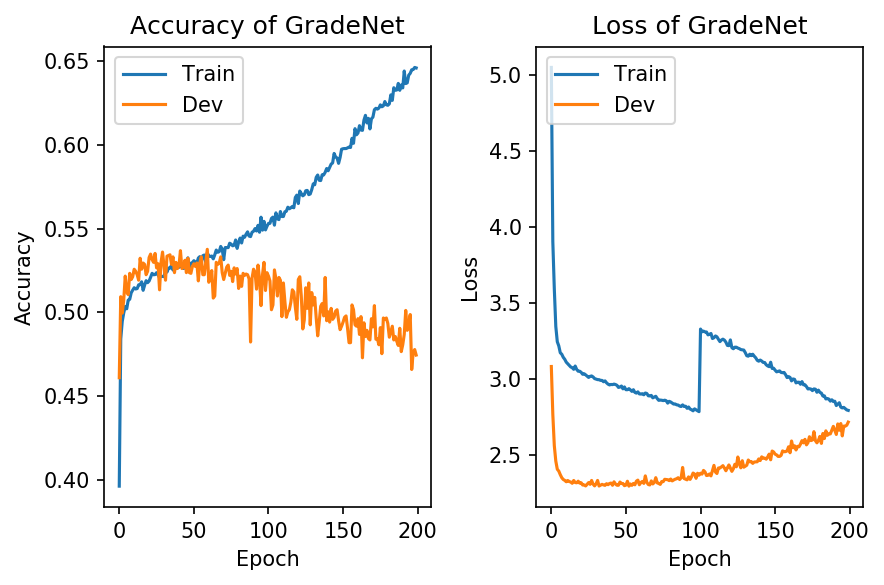

In [336]:
GradeNet_history_package = plot_history(history_GradeNet, 'GradeNet')

### Save training results

In [ ]:
# saving trained results
save_pickle(GradeNet_history_package, 'GradeNet_train_history')
GradeNet.save_weights("GradeNet.h5")

## 2-2. Loading pretrained GradeNet

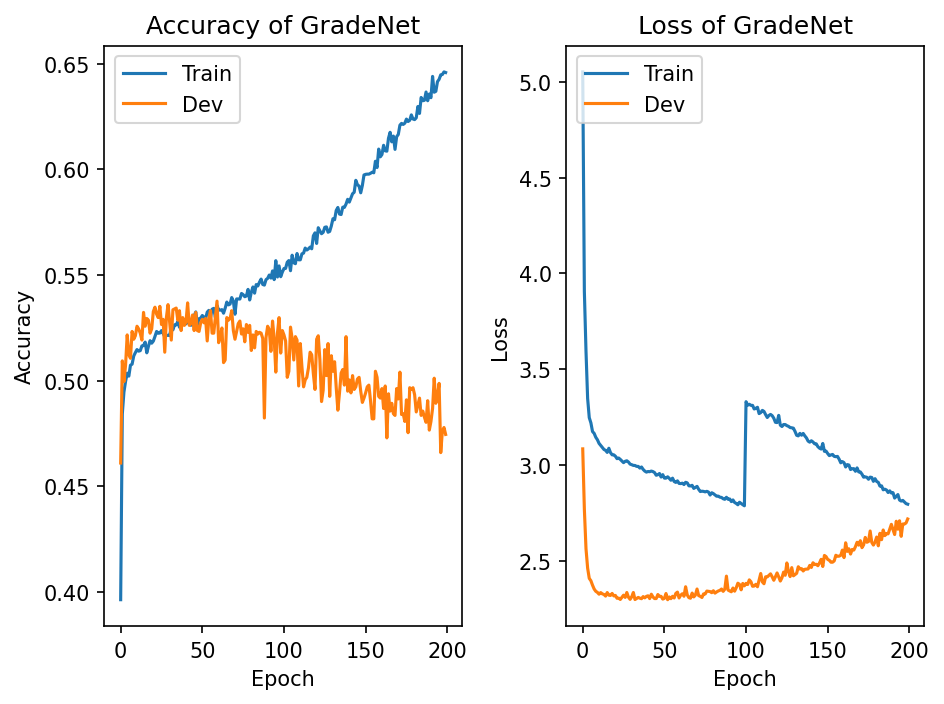

In [20]:
# load model weight
GradeNet.load_weights(parent_wd + '/model/GradeNet.h5')

# load training history
history_path = parent_wd + '/model/GradeNet_train_history'
with open(history_path, 'rb') as f:
    GradeNet_history_package = pickle.load(f)

plot_history_package(GradeNet_history_package, 'GradeNet')

## 3. Analyze GradeNet Performance

### Confusion Matrix

630/630 [==============================] - 3s 5ms/step


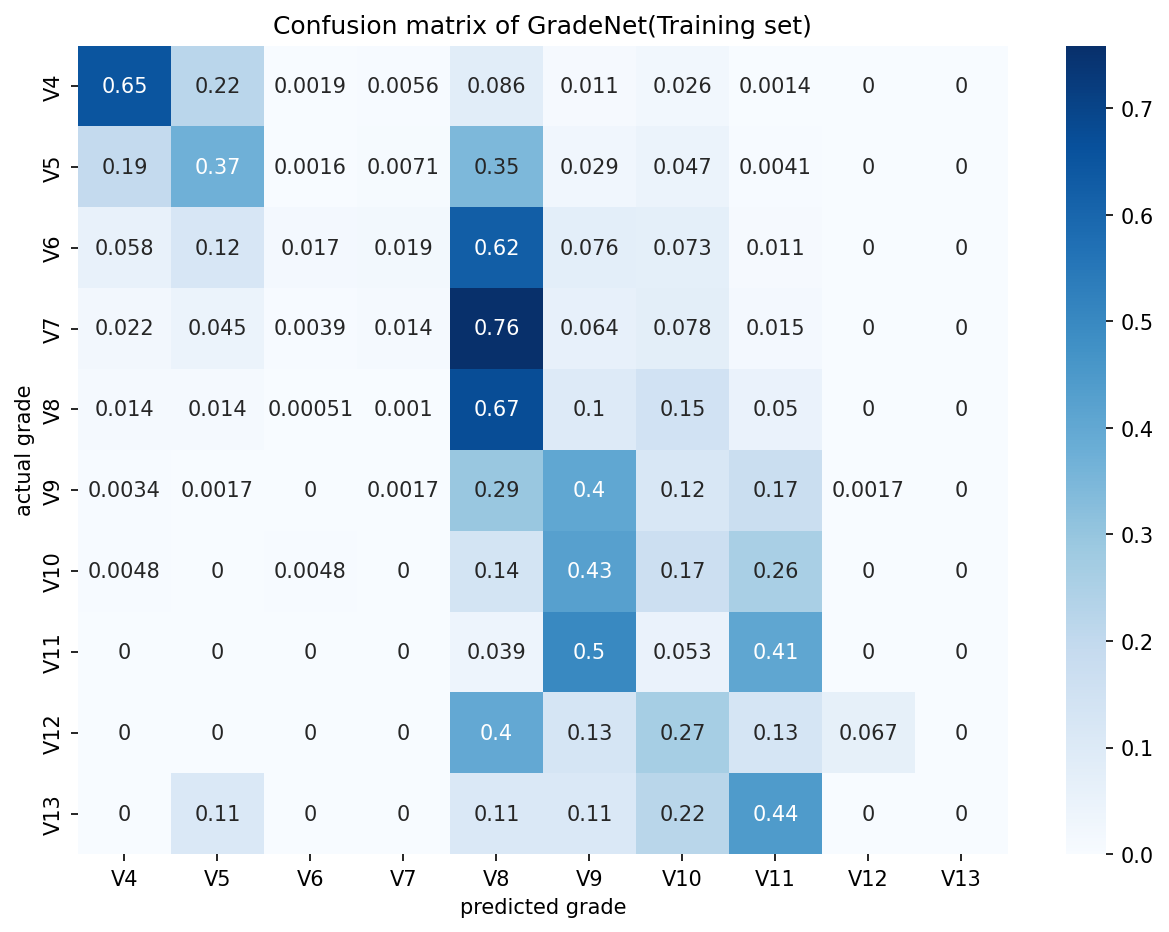

In [21]:
plot_confusion_matrix(Y_train, GradeNet.predict(X_train).argmax(axis=1), title = 'Confusion matrix of GradeNet(Training set)')

77/77 [==============================] - 0s 5ms/step


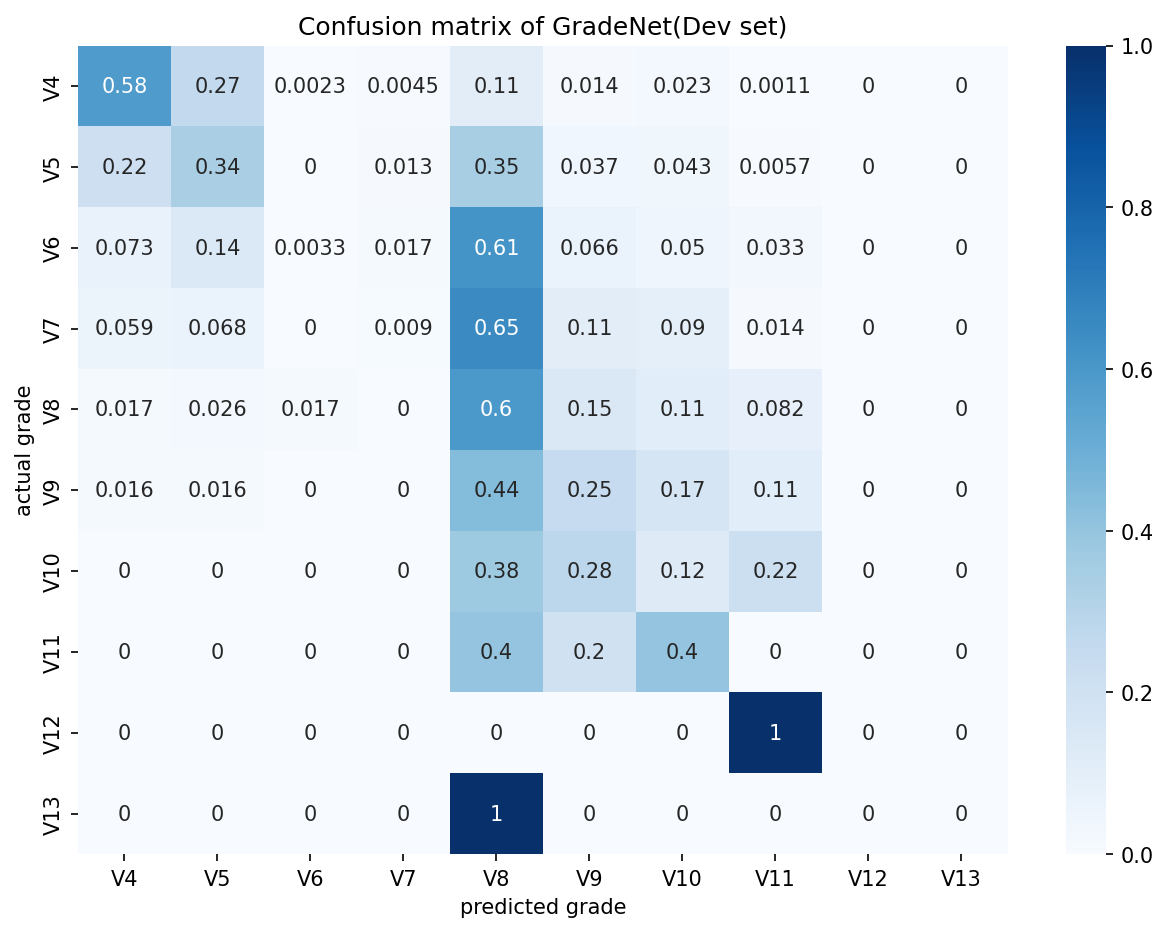

In [22]:
plot_confusion_matrix(Y_dev, GradeNet.predict(X_dev).argmax(axis=1), title = 'Confusion matrix of GradeNet(Dev set)')

79/79 [==============================] - 0s 4ms/step


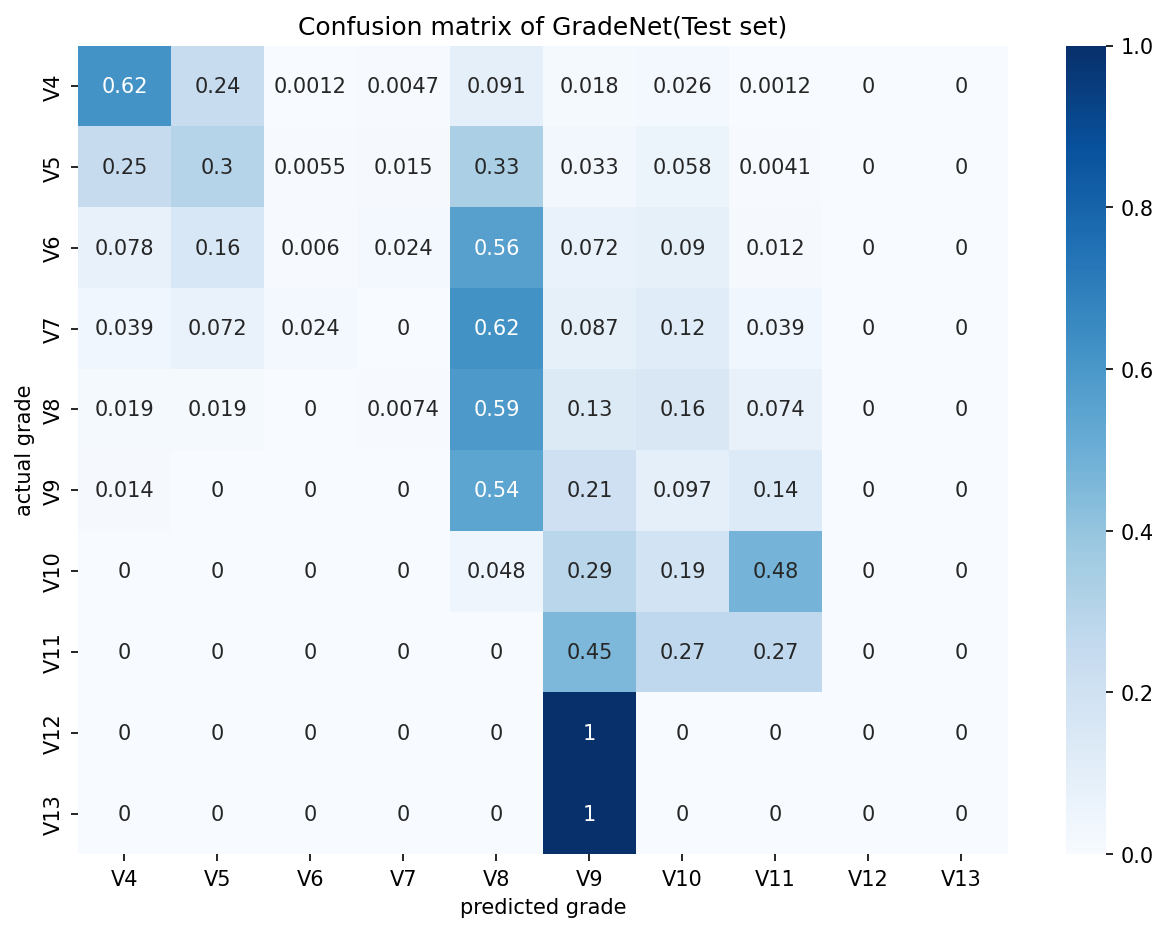

In [23]:
plot_confusion_matrix(Y_test, GradeNet.predict(X_test).argmax(axis=1), title = 'Confusion matrix of GradeNet(Test set)')

### F1 score

In [10]:
F1_train = metrics.f1_score(Y_train, GradeNet.predict(X_train).argmax(axis=1), average = 'macro')
print(F1_train)

0.5057003231041498


In [11]:
F1_dev = metrics.f1_score(Y_dev, GradeNet.predict(X_dev).argmax(axis=1), average = 'macro')
print(F1_dev)

0.2415038991517887


In [12]:
F1_test = metrics.f1_score(Y_test, GradeNet.predict(X_test).argmax(axis=1), average = 'macro')
print(F1_test)

0.25462859135503807


### Accuracy and Rough accuracy

In [16]:
accuracy_train = compute_accuracy(Y_train, GradeNet.predict(X_train).argmax(axis=1))
print("Exactly accuracy rate of training set = %s" %accuracy_train[0])
print("+/-1 Accuracy rate of training set= %s" %accuracy_train[1])

Exactly accuracy rate of training set = 0.6426551570174133
+/-1 Accuracy rate of training set= 0.9129334722428933


In [17]:
accuracy_dev = compute_accuracy(Y_dev, GradeNet.predict(X_dev).argmax(axis=1))
print("Exactly accuracy rate of dev set = %s" %accuracy_dev[0])
print("+/-1 Accuracy rate of dev set = %s" %accuracy_dev[1])

Exactly accuracy rate of dev set = 0.4746109746109746
+/-1 Accuracy rate of dev set = 0.8484848484848485


In [18]:
accuracy_test = compute_accuracy(Y_test, GradeNet.predict(X_test).argmax(axis=1))
print("Exactly accuracy rate of test set = %s" %accuracy_test[0])
print("+/-1 Accuracy rate of test set = %s" %accuracy_test[1])

Exactly accuracy rate of test set = 0.46655987184621545
+/-1 Accuracy rate of test set = 0.8474169002803364


### KL divergence

In [19]:
kl = tf.keras.losses.KLDivergence()

kld_train = kl(tf.one_hot(Y_train.astype(int), depth = 10), GradeNet.predict(X_train)).numpy()
print(kld_train)

kld_dev = kl(tf.one_hot(Y_dev.astype(int), depth = 10), GradeNet.predict(X_dev)).numpy()
print(kld_dev)

kld_test = kl(tf.one_hot(Y_test.astype(int), depth = 10), GradeNet.predict(X_test)).numpy()
print(kld_test)

0.86333936
1.3504114
1.392339


### Mean absolute error

In [20]:
# MAE
mae_train = np.mean(np.abs(Y_train - GradeNet.predict(X_train).argmax(axis=1)))
print(mae_train)

mae_dev = np.mean(np.abs(Y_dev - GradeNet.predict(X_dev).argmax(axis=1)))
print(mae_dev)

mae_test = np.mean(np.abs(Y_test - GradeNet.predict(X_test).argmax(axis=1)))
print(mae_test)

0.4649997519472144
0.733005733005733
0.7404885863035643


### Classification report

In [21]:
sk_report_train = metrics.classification_report(
    digits=4,
    y_true=Y_train, 
    y_pred=GradeNet.predict(X_train).argmax(axis=1))
print(sk_report_train)

sk_report_dev = metrics.classification_report(
    digits=4,
    y_true=Y_dev, 
    y_pred=GradeNet.predict(X_dev).argmax(axis=1))
print(sk_report_dev)

sk_report_test = metrics.classification_report(
    digits=4,
    y_true=Y_test, 
    y_pred=GradeNet.predict(X_test).argmax(axis=1))
print(sk_report_test)

              precision    recall  f1-score   support

         0.0     0.7877    0.8243    0.8056      7285
         1.0     0.6600    0.5874    0.6216      5625
         2.0     0.4265    0.6566    0.5171      2586
         3.0     0.3452    0.2468    0.2878      1811
         4.0     0.6763    0.5135    0.5838      1961
         5.0     0.6905    0.6000    0.6421       580
         6.0     0.5732    0.4498    0.5040       209
         7.0     0.5476    0.6053    0.5750        76
         8.0     0.4000    0.2667    0.3200        15
         9.0     1.0000    0.1111    0.2000         9

    accuracy                         0.6427     20157
   macro avg     0.6107    0.4861    0.5057     20157
weighted avg     0.6490    0.6427    0.6398     20157



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0     0.7086    0.7214    0.7149       883
         1.0     0.4502    0.4182    0.4336       703
         2.0     0.2453    0.3920    0.3018       301
         3.0     0.2071    0.1584    0.1795       221
         4.0     0.3671    0.2511    0.2982       231
         5.0     0.2407    0.2031    0.2203        64
         6.0     0.2308    0.0938    0.1333        32
         7.0     0.1000    0.2000    0.1333         5
         8.0     0.0000    0.0000    0.0000         1
         9.0     0.0000    0.0000    0.0000         1

    accuracy                         0.4746      2442
   macro avg     0.2550    0.2438    0.2415      2442
weighted avg     0.4791    0.4746    0.4728      2442

              precision    recall  f1-score   support

         0.0     0.6757    0.7263    0.7001       855
         1.0     0.4637    0.4050    0.4324       726
         2.0     0.2516    0.3533    0.2939       334
         3.0     0.1875 

In [23]:
AUC_train = metrics.roc_auc_score(Y_train, GradeNet.predict(X_train), multi_class= 'ovr', average="macro")
print(AUC_train)

AUC_dev = metrics.roc_auc_score(Y_dev, GradeNet.predict(X_dev), multi_class= 'ovr', average="macro")
print(AUC_dev)

AUC_test = metrics.roc_auc_score(Y_test, GradeNet.predict(X_test), multi_class= 'ovr', average="macro")
print(AUC_test)

0.9422221701987953
0.8626394146312968
0.8701816011490345
